File 'pp2.csv' not found. Please upload it.


Saving PP2.csv to PP2.csv

QUANTUM ECONOPHYSICS REPORT: NIFTY 50 ANALYSIS

>>> 1. STATISTICAL VALIDATION
   * Hurst Exponent (H): 0.3872 (Mean Reverting)
   * Fractal Dimension:  1.6128
   * Kurtosis:           22.7583 (Fat Tails)
   * Normality (p-val):  0.000000 (Non-Gaussian)


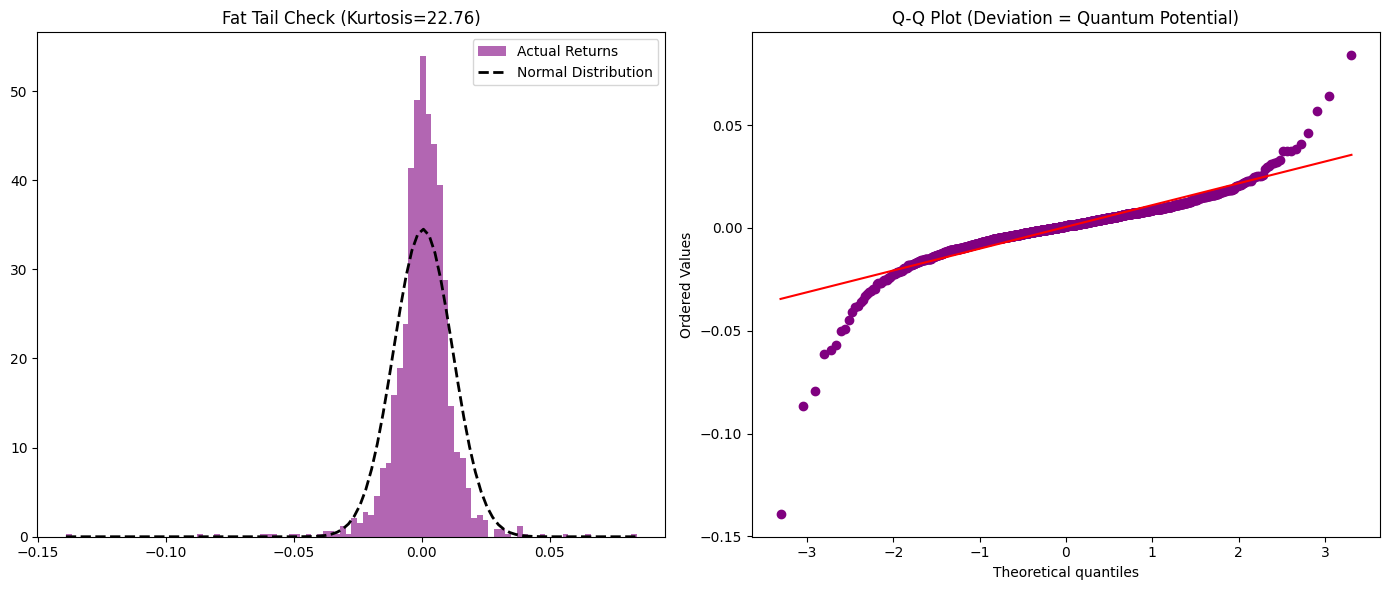

------------------------------------------------------------

>>> 2. DYNAMIC QUANTUM RISK (Q-VIX)
   * Current Wall Width: 1.00%
   * Average Wall Width: 1.01%


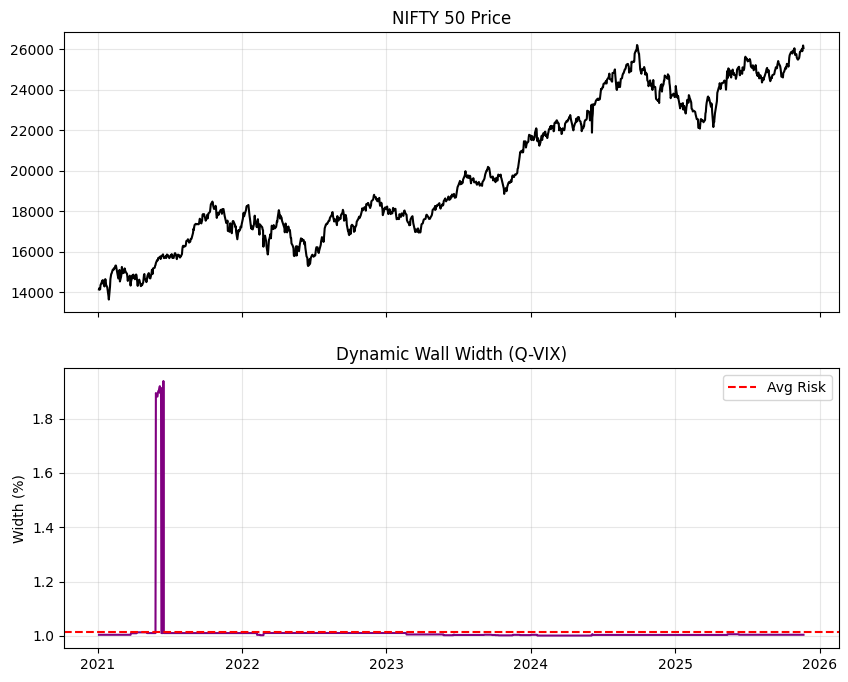

------------------------------------------------------------

>>> 3. 2D QUANTUM FORCE VECTOR ANALYSIS
   * Max Instability Point: Return -11.43%, Vol 0.35
   * Escape Force Vector:   Magnitude 3.5140, Angle 179.82°


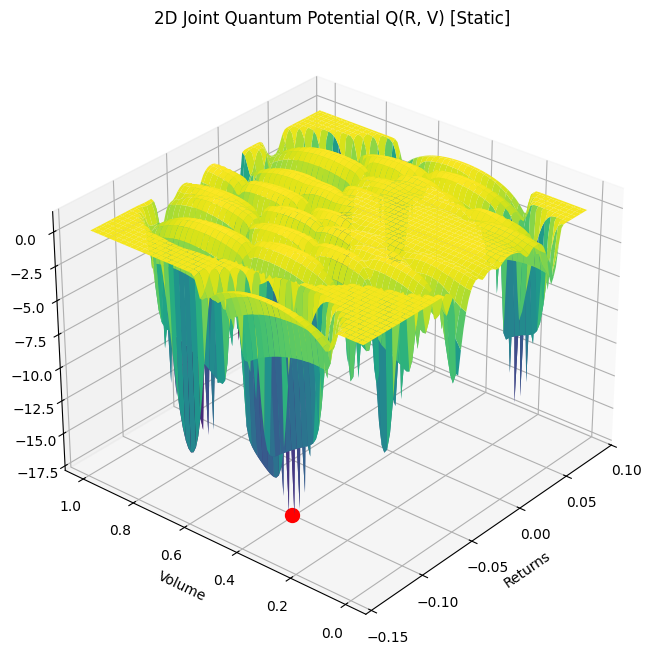


>>> GENERATING INTERACTIVE 3D MAP (See Output Below)...


------------------------------------------------------------

>>> 4. BACKTEST PERFORMANCE
   * Time Within Principal Range: 48.02%
   * Quantum Wall Bounce Rate:    43.36%
   * Quantum Wall Breakout Rate:  56.64%

[SUCCESS] Full Report generated. PDF saved as 'Quantum_Analysis_Report.pdf'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde, jarque_bera, norm, probplot
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION & DATA LOADING
# ==========================================
FILENAME = 'pp2.csv'
WINDOW_SIZE = 252
PDF_FILENAME = 'Quantum_Analysis_Report.pdf'

# Auto-upload block (for Colab)
if not os.path.exists(FILENAME):
    if os.path.exists('pp2'): FILENAME = 'pp2'
    else:
        print(f"File '{FILENAME}' not found. Please upload it.")
        try:
            from google.colab import files
            uploaded = files.upload()
            FILENAME = list(uploaded.keys())[0]
        except: pass

def get_clean_data(filepath):
    try:
        df = pd.read_csv(filepath)
        df.columns = df.columns.str.strip()
        if 'Price' in df.columns: df.rename(columns={'Price': 'Close'}, inplace=True)
        elif len(df.columns) >= 2: df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'Close'}, inplace=True)
        if 'Vol.' in df.columns: df.rename(columns={'Vol.': 'Volume'}, inplace=True)
        if 'Volume' not in df.columns and len(df.columns) >= 3: df.rename(columns={df.columns[2]: 'Volume'}, inplace=True)
        if 'Volume' in df.columns and df['Volume'].dtype == object:
                df['Volume'] = df['Volume'].astype(str).str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').astype(float)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Log_Price'] = np.log(df['Close'])
        if 'Volume' in df.columns:
             df['Volume_Norm'] = (df['Volume'] - df['Volume'].min()) / (df['Volume'].max() - df['Volume'].min())
        return df.dropna()
    except Exception as e:
        print(f"Error: {e}")
        return None

# ==========================================
# 2. ANALYTICAL FUNCTIONS
# ==========================================

def get_hurst(time_series, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

def calculate_quantum_potential_1d(returns, bandwidth_factor=3.0):
    kde = gaussian_kde(returns, bw_method='scott')
    kde.set_bandwidth(kde.factor * bandwidth_factor)
    x_grid = np.linspace(returns.min()*1.5, returns.max()*1.5, 2000)
    P = kde(x_grid)
    epsilon = 1e-9
    sqrt_P = np.sqrt(P + epsilon)
    d_sqrt_P = np.gradient(sqrt_P, x_grid)
    d2_sqrt_P = np.gradient(d_sqrt_P, x_grid)
    Q = -(1 / sqrt_P) * d2_sqrt_P
    return x_grid, Q

def get_walls(x_grid, Q, threshold=50):
    wall_indices = np.where(Q > threshold)[0]
    if len(wall_indices) == 0: return 0, 0
    left_cands = x_grid[wall_indices[x_grid[wall_indices] < -0.005]]
    right_cands = x_grid[wall_indices[x_grid[wall_indices] > 0.005]]
    left = np.max(left_cands) if len(left_cands) > 0 else x_grid[0]
    right = np.min(right_cands) if len(right_cands) > 0 else x_grid[-1]
    return left, right

# ==========================================
# 3. REPORT GENERATION & PLOTTING
# ==========================================

def generate_report(df):
    print("\n" + "="*60)
    print("QUANTUM ECONOPHYSICS REPORT: NIFTY 50 ANALYSIS")
    print("="*60 + "\n")

    pdf = PdfPages(PDF_FILENAME)

    # --- SECTION 1: STATISTICAL VALIDATION ---
    print(">>> 1. STATISTICAL VALIDATION")
    hurst = get_hurst(df['Log_Price'].values, max_lag=300)
    fractal_dim = 2 - hurst
    kurt = df['Log_Ret'].kurtosis()
    jb_stat, jb_p = jarque_bera(df['Log_Ret'])

    print(f"   * Hurst Exponent (H): {hurst:.4f} ({'Mean Reverting' if hurst < 0.5 else 'Trending'})")
    print(f"   * Fractal Dimension:  {fractal_dim:.4f}")
    print(f"   * Kurtosis:           {kurt:.4f} ({'Fat Tails' if kurt > 3 else 'Normal'})")
    print(f"   * Normality (p-val):  {jb_p:.6f} ({'Non-Gaussian' if jb_p < 0.05 else 'Gaussian'})")

    # Plot 1: Histogram & Q-Q Plot
    fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram
    ax1a.hist(df['Log_Ret'], bins=100, density=True, alpha=0.6, color='purple', label='Actual Returns')
    mu, std = df['Log_Ret'].mean(), df['Log_Ret'].std()
    x = np.linspace(df['Log_Ret'].min(), df['Log_Ret'].max(), 100)
    p = norm.pdf(x, mu, std)
    ax1a.plot(x, p, 'k--', linewidth=2, label='Normal Distribution')
    ax1a.set_title(f"Fat Tail Check (Kurtosis={kurt:.2f})")
    ax1a.legend()

    # Q-Q Plot
    probplot(df['Log_Ret'], dist="norm", plot=ax1b)
    ax1b.set_title("Q-Q Plot (Deviation = Quantum Potential)")
    ax1b.get_lines()[0].set_markerfacecolor('purple')
    ax1b.get_lines()[0].set_markeredgecolor('purple')

    plt.tight_layout()
    pdf.savefig(fig1)
    plt.show()
    print("-" * 60)

    # --- SECTION 2: DYNAMIC RISK (ROLLING WALLS) ---
    print("\n>>> 2. DYNAMIC QUANTUM RISK (Q-VIX)")

    wall_widths = []
    dates = []

    for i in range(WINDOW_SIZE, len(df)):
        window = df['Log_Ret'].iloc[i-WINDOW_SIZE:i]
        try:
            xg, q_vals = calculate_quantum_potential_1d(window, bandwidth_factor=1.5)
            l, r = get_walls(xg, q_vals, threshold=30)
            wall_widths.append(r - l)
            dates.append(df.index[i])
        except:
            wall_widths.append(np.nan)
            dates.append(df.index[i])

    risk_df = pd.DataFrame({'Wall_Width': wall_widths}, index=dates).dropna()
    current_risk = risk_df['Wall_Width'].iloc[-1]

    print(f"   * Current Wall Width: {current_risk*100:.2f}%")
    print(f"   * Average Wall Width: {risk_df['Wall_Width'].mean()*100:.2f}%")

    # Plot 2: Dynamic Risk
    fig2, (ax2a, ax2b) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax2a.plot(df.index[WINDOW_SIZE:], df['Close'].iloc[WINDOW_SIZE:], color='black')
    ax2a.set_title("NIFTY 50 Price")
    ax2a.grid(True, alpha=0.3)

    ax2b.plot(risk_df.index, risk_df['Wall_Width']*100, color='purple')
    ax2b.axhline(risk_df['Wall_Width'].mean()*100, color='red', linestyle='--', label='Avg Risk')
    ax2b.set_title("Dynamic Wall Width (Q-VIX)")
    ax2b.set_ylabel("Width (%)")
    ax2b.legend()
    ax2b.grid(True, alpha=0.3)
    pdf.savefig(fig2)
    plt.show()
    print("-" * 60)

    # --- SECTION 3: 2D PHYSICS (FORCE VECTOR) ---
    print("\n>>> 3. 2D QUANTUM FORCE VECTOR ANALYSIS")

    if 'Volume_Norm' in df.columns:
        data_2d = df[['Log_Ret', 'Volume_Norm']].dropna()
        values = data_2d.values.T
        kde = gaussian_kde(values, bw_method='silverman')

        xmin, xmax = values[0].min(), values[0].max()
        ymin, ymax = values[1].min(), values[1].max()
        # High res for calculation
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        P = kde(positions).reshape(X.shape)

        sqrt_P = np.sqrt(P + 1e-12)
        d2_dx2 = np.gradient(np.gradient(sqrt_P, axis=0), axis=0)
        d2_dy2 = np.gradient(np.gradient(sqrt_P, axis=1), axis=1)
        Q_2d = -(1 / sqrt_P) * (d2_dx2 + d2_dy2)

        min_idx = np.unravel_index(Q_2d.argmin(), Q_2d.shape)
        min_R = X[min_idx]
        min_V = Y[min_idx]
        min_Q = Q_2d[min_idx]

        grad_R = np.gradient(Q_2d, axis=0)
        grad_V = np.gradient(Q_2d, axis=1)
        force_R = -grad_R[min_idx]
        force_V = -grad_V[min_idx]
        force_mag = np.sqrt(force_R**2 + force_V**2)
        force_angle = np.degrees(np.arctan2(force_V, force_R))

        print(f"   * Max Instability Point: Return {min_R*100:.2f}%, Vol {min_V:.2f}")
        print(f"   * Escape Force Vector:   Magnitude {force_mag:.4f}, Angle {force_angle:.2f}°")

        # Plot 3: Static 2D Potential Surface (For PDF)
        fig3 = plt.figure(figsize=(10, 8))
        ax3 = fig3.add_subplot(111, projection='3d')
        Q_clipped = np.clip(Q_2d, -100, 100)
        surf = ax3.plot_surface(X, Y, Q_clipped, cmap='viridis', linewidth=0, antialiased=True)
        ax3.scatter([min_R], [min_V], [min_Q], color='red', s=100, label='Max Instability')
        ax3.set_title("2D Joint Quantum Potential Q(R, V) [Static]")
        ax3.set_xlabel("Returns")
        ax3.set_ylabel("Volume")
        ax3.view_init(elev=30, azim=220)
        pdf.savefig(fig3)
        plt.show() # Show Static Version

        # ---------------------------------------------
        # *** INTERACTIVE 3D PLOT (Notebook Only) ***
        # ---------------------------------------------
        print("\n>>> GENERATING INTERACTIVE 3D MAP (See Output Below)...")
        fig_interactive = go.Figure(data=[
            go.Surface(
                z=Q_clipped.T,
                x=X[:, 0],
                y=Y[0, :],
                colorscale='Viridis',
                colorbar_title='Quantum Potential Q',
                name='Q(R, V)'
            )
        ])
        # Mark Max Instability
        fig_interactive.add_trace(go.Scatter3d(
            x=[min_R], y=[min_V], z=[min_Q],
            mode='markers',
            marker=dict(size=8, color='red', symbol='x'),
            name='Max Instability'
        ))
        fig_interactive.update_layout(
            title='Interactive 2D Joint Quantum Potential',
            scene=dict(
                xaxis_title='Log Returns (R)',
                yaxis_title='Normalized Volume (V)',
                zaxis_title='Quantum Potential Q'
            ),
            width=800, height=600
        )
        fig_interactive.show()

    else:
        print("   (Volume data not available for 2D analysis)")
    print("-" * 60)

    # --- SECTION 4: BACKTEST STATISTICS ---
    print("\n>>> 4. BACKTEST PERFORMANCE")
    xg, qg = calculate_quantum_potential_1d(df['Log_Ret'])
    glob_l, glob_r = get_walls(xg, qg)

    inside = df[(df['Log_Ret'] > glob_l) & (df['Log_Ret'] < glob_r)]
    pct_inside = (len(inside) / len(df)) * 100

    df['Next_Ret'] = df['Log_Ret'].shift(-1)
    hits_l = df[df['Log_Ret'] < glob_l]
    hits_r = df[df['Log_Ret'] > glob_r]
    wins_l = len(hits_l[hits_l['Next_Ret'] > 0])
    wins_r = len(hits_r[hits_r['Next_Ret'] < 0])
    total_hits = len(hits_l) + len(hits_r)
    win_rate = ((wins_l + wins_r) / total_hits * 100) if total_hits > 0 else 0

    print(f"   * Time Within Principal Range: {pct_inside:.2f}%")
    print(f"   * Quantum Wall Bounce Rate:    {win_rate:.2f}%")
    print(f"   * Quantum Wall Breakout Rate:  {100 - win_rate:.2f}%")
    print(f"\n[SUCCESS] Full Report generated. PDF saved as '{PDF_FILENAME}'")

    pdf.close()

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    df = get_clean_data(FILENAME)
    if df is not None:
        generate_report(df)